In [1]:
import os
import sys
import xlrd
import logging

import numpy as np
import pandas as pd

In [2]:
root_logger = logging.getLogger()
root_logger.handlers = []

class Logger:
    def __init__(self, name):
        self.logger = None
        self.name = name
    
    def create_logger(self):
    
        if self.logger is None:
            self.logger = logging.getLogger(self.name)
            self.logger.setLevel(logging.INFO)
            self.logger.propagate = False

            self.logger.handlers=[]

            stream_handler = logging.StreamHandler(sys.stderr)
            formatter = logging.Formatter(
                "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s", "%Y-%m-%d %H:%M:%S"
            )
            stream_handler.setFormatter(formatter)

            stream_handler.setLevel(logging.DEBUG)
            self.logger.addHandler(stream_handler)
        
        return self.logger

In [3]:
logger = Logger(name="Claim")
mylogger = logger.create_logger()

def read_if_exist_decorator(get_data):
    def _read_file_if_exists(*args, **kwargs):
        try:
            filename = kwargs["filename"]
            if os.path.exists(filename):
                try:
                    data = pd.read_csv(filename)
                    mylogger.info("Data loaded from file {}".format(filename))
                except pd.errors.ParserError:
                    with open(filename, 'rb') as f:
                        items = list(ijson.items(f, '', use_float=True))
                    if len(items) > 0:
                        data = items[0]
                        logging.info("Data loaded from file {}".format(filename))
                except Exception:
                    data = None
                    mylogger.info("File {} was found but no data was loaded".format(filename))
            else:
                data = None
                mylogger.info("File {} not found. No data was loaded".format(filename))
            kwargs["filename"] = filename
            return get_data(data=data, *args, **kwargs)
        except Exception as e:
            raise Exception(e)
    return _read_file_if_exists

def save_data_to_csv(data, filename, **kwargs):
    """
        Save df to csv
        :param data: df to save
        :param filename: path to file
        :param kwargs: additional arguments for DataFrame.to_csv method
    """
    dirname = os.path.dirname(filename)
    os.makedirs(dirname, exist_ok=True)
    data.to_csv(filename, **kwargs)

@read_if_exist_decorator
def extract_claim_data(filename, input_files, data=None):
    
    if data is None:
        file_data = []
        
        for file in input_files:
            mylogger.info("Loading file {}".format(file))
            try:
                file_data.append(pd.read_excel(file))
            except Exception as e:
                mylogger.info("Input Excel file is not readable: {}".format(e))
        
        data = pd.concat(file_data)
        
        mylogger.info("Total number of claims: {}".format(data.shape[0]))
        
        save_data_to_csv(data, filename, index=False)
    
    return data

In [4]:
data_path = '/Users/user/Documents/Pentatonic/Travelers/data'
raw_data_file = '{}/Pentatonic_Xact_Categories_5yr_raw.csv'.format(data_path)
claim_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and "Xact_Categories" in f and f.endswith(".xlsx")]

logging.info("Processing files {}".format(claim_files))
data = extract_claim_data(filename=raw_data_file, input_files=claim_files)




[2021-09-09 15:13:51] [Claim] [INFO] Data loaded from file /Users/user/Documents/Pentatonic/Travelers/data/Pentatonic_Xact_Categories_5yr_raw.csv


In [5]:
rename_map = {
    "category_description" : "subcategory",
    "ITM_TYP_DESC_2" : "item_description",
    "DIV_CD" : "div_cd",
    "LS_YYMM" : "ls_date",
    "peril_grp" : "reason",
    "ITM_UNIT_CD" : "item_unit_cd",
    "ITM_QTY" : "item_quantity",
    "count1" : "count"
}

import

In [6]:
from abc import ABC, abstractmethod

class Transformation(ABC):
    """
    Implements abstract Transformation operation that can be inherited by common DataFrame transformations
    such as preprocessing or feature calculation in order to standardise framework
    """
    def __init__(self, input_cols, output_col, calculation_func, *args, **kwargs):
        """
        :param input_cols:                  string or iterable of input column names for transformation calculation
                                            (if iterable, it must have the same order as columns passed to
                                            `calculation_func`)
        :param output_col:                  output column name for calculated transformation
        :param calculation_func:            calculation function that takes one or multiple Series objects of
                                            correspondent input columns as arguments and returns calculation result
        """
        if isinstance(input_cols, str):
            self.input_cols = [input_cols]
        else:
            self.input_cols = input_cols
        self.output_col = output_col
        self.calculation_func = calculation_func
        self.args = args
        self.kwargs = kwargs

    @abstractmethod
    def __repr__(self):
        pass

    def calculate(self, df):
        """
        Performs calculations on an input DataFrame using columns defined in `self.input_cols` and calculation in
        `self.calculation_func`
        :param df:                          an input DataFrame
        :return:                            result of the transformation calculation
        """
        for input_col in self.input_cols:
            if input_col not in df.columns:
                raise KeyError(
                    "{}: input column "
                    "{} wasn't found in provided DataFrame "
                    "for {} calculation".format(self.__class__.__name__, input_col, self.output_col)
                )
        return self.calculation_func(*[df[input_col] for input_col in self.input_cols], *self.args, **self.kwargs)

class Preprocessor:
    """
    Implements preprocessor to apply multiple standardized preprocess operations on a data DataFrame
    """
    def __init__(self, transformations):
        """
        :param transformations:             an iterable of `PreprocessTransformation` objects to apply
        """
        self.transformations = transformations

    def calculate(self, data):
        """
        Calculates all provided preprocessing transformations on an input DataFrame
        :param data:                        an input DataFrame
        :return:                            a DataFrame with all preprocessing transformations applied
        """
        for transformation in self.transformations:
            data[transformation.output_col] = transformation.calculate(data)
        return data


class PreprocessTransformation(Transformation):
    """
    Implements preprocess transformation object that carries information about input/output columns and required
    calculation in order to standardise preprocessing framework
    """
    def __init__(self, input_cols, output_col, calculation_func, *args, **kwargs):
        """
        PreprocessorTransformation initialization
        :param input_cols:                  string or iterable of input column names for preprocessing
                                            (if iterable, it must have the same order as columns passed to
                                            `calculation_func`)
        :param output_col:                  output column name for calculated transformation
        :param calculation_func:            string or function object:
                                                - if string then correspondent transformation method from the current
                                                  class is called
                                                - otherwise it must be a calculation function that takes one or multiple
                                                  Series objects of correspondent input columns as arguments and returns
                                                  a new Series object of the same size as input
        """
        super().__init__(input_cols, output_col, calculation_func, *args, **kwargs)
        if isinstance(calculation_func, str):
            self.calculation_func = getattr(self, calculation_func)
        self.fill_na_forward_backward_by_book_median = None
        self.fill_na_maxprice_median = None
        self.fill_na_amazonaveragerating_medians = None

    def __repr__(self):
        """PreprocessTransformation string representation
        """
        return "PreprocessTransformation(input={}, output={})".format(self.input_cols, self.output_col)
        
    @staticmethod
    def to_numeric(col):
        """Transforms column to numeric format
        """
        # check if column is already numeric
        if np.issubdtype(col.dtype, np.number):
            return col
        col = pd.to_numeric(col, errors="coerce")
        num_non_numeric = col.isna().sum()
        if num_non_numeric > 0:
            mylogger.warning(
                "to_numeric conversion couldn't parse {} "
                "non-numeric values in `{}` column".format(num_non_numeric, col.name)
            )
        return col
    
    @staticmethod
    def strip_and_lower(col):
        """Transforms string column to lower case and strips leading and trailing spaces
        """
        return col.str.strip().str.lower()

    @staticmethod
    def empty_string_to_na(col):
        """Transforms string column to lower case and strips leading and trailing spaces
        """
        transformed = col.mask(col == "", np.nan)
        num_transformed = transformed.isna().sum() - col.isna().sum()
        if num_transformed > 0:
            mylogger.warning(
                "{} empty strings were replaced with NaNs in column `{}`".format(num_transformed, col.name)
            )
        return transformed
    
    @staticmethod
    def fill_na_with_value(col, value):
        """Fills missing values with provided value
        """
        na_num = col.isna().sum()
        if na_num > 0:
            mylogger.warning("{} NA values were found in column `{}` filled with `{}`".format(na_num, col.name, value))
            return col.fillna(value=value)
        else:
            return col

In [8]:
import nltk
from nltk.corpus import stopwords

import functools

ENGLISH_STOP_WORDS = stopwords.words('english') + ['per', 'one', 'two', 'three', 'four', 'five', 'six', 
                                                   'seven', 'eight', 'nine', 'ten',
                                                  'lb', 'kg', 'lf', 'sf', 'yr',
                                                  'anti', 'full', 'large', 'small', 'high', 'hour',
                                                  'period', 'rfg']

mylogger.info("Stop words: {}".format(ENGLISH_STOP_WORDS))

def strip_values(col):
    """
    Strips leading and trailing spaces
    :param col                          an input column Series object
    """
    return col.str.strip()


def remove_extra_spaces(col):
    """
    Remove two and more successive empty spaces
    :param col                          an input column Series object
    """
    return col.str.replace(r"\s\s+", " ")

def remove_spaces_and_strip(func):
    """Remove extra spaces and strip values"""
    @functools.wraps(func)
    def wrapper_remove_and_strip(*args, **kwargs):
        col_preprocessed = func(*args, **kwargs)
        col_preprocessed = remove_extra_spaces(col_preprocessed)
        col_preprocessed = strip_values(col_preprocessed)
        return col_preprocessed
    return wrapper_remove_and_strip


@remove_spaces_and_strip
def remove_punctuation(col):
    """
    Replace delimiters with an empty space
    :param col                          an input column Series object
    """
    return col.str.replace(r"[^\w\s]+", " ")

#the, is, at, which, and on
@remove_spaces_and_strip
def remove_stop_words(col, stopwords=ENGLISH_STOP_WORDS):
    """
    Replace stopwords by space
    Default patterns:  ENGLISH_STOP_WORDS
    :param col                          an input column Series object
    :param stopwords                    a tuple of genre to replace
    """
    col_copy = col.copy()
    col_copy = col_copy.str.split(" ")
    col_copy = col_copy.apply(lambda row: [word.strip() for word in row if word.strip() not in stopwords])
    col_copy = col_copy.str.join(" ")
    return col_copy

@remove_spaces_and_strip
def remove_non_alphabetical_words(col):
    """
    Replace words containing non-alphabetical symbols by space
    Default patterns:  ENGLISH_STOP_WORDS
    :param col                          an input column Series object
    :param stopwords                    a tuple of genre to replace
    """
    col_copy = col.copy()
    col_copy = col_copy.str.split(" ")
    col_copy = col_copy.apply(lambda row: [word.strip() for word in row if word.isalpha()])
    col_copy = col_copy.str.join(" ")
    return col_copy

@remove_spaces_and_strip
def remove_one_letter_words(col):
    """
    Replace words containing non-alphabetical symbols by space
    Default patterns:  ENGLISH_STOP_WORDS
    :param col                          an input column Series object
    :param stopwords                    a tuple of genre to replace
    """
    col_copy = col.copy()
    col_copy = col_copy.str.split(" ")
    col_copy = col_copy.apply(lambda row: [word.strip() for word in row if len(word) > 1])
    col_copy = col_copy.str.join(" ")
    return col_copy

[2021-09-09 15:14:43] [Claim] [INFO] Stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'no

In [9]:
BASIC_PREPROCESS = [
    PreprocessTransformation("subcategory", "subcategory", "fill_na_with_value", ""),
    PreprocessTransformation("subcategory", "subcategory", remove_punctuation),
    PreprocessTransformation("subcategory", "subcategory", remove_stop_words),
    PreprocessTransformation("subcategory", "subcategory", remove_non_alphabetical_words),
    PreprocessTransformation("subcategory", "subcategory", remove_one_letter_words),
    PreprocessTransformation("subcategory", "subcategory", "strip_and_lower"),
    PreprocessTransformation("item_description", "item_description", "fill_na_with_value", ""),
    PreprocessTransformation("item_description", "item_description", remove_punctuation),
    PreprocessTransformation("item_description", "item_description", remove_stop_words),
    PreprocessTransformation("item_description", "item_description", remove_non_alphabetical_words),
    PreprocessTransformation("item_description", "item_description", remove_one_letter_words),
    PreprocessTransformation("item_description", "item_description", "strip_and_lower")
]

In [10]:
basic_preprocessor = Preprocessor(BASIC_PREPROCESS)
data = basic_preprocessor.calculate(data)

processed_file = '{}/Pentatonic_Xact_Categories_5yr_processed.csv'.format(data_path)
save_data_to_csv(data, processed_file, index=False)

<ipython-input-8-9ddd8ddf1452>:46: FutureWarning: The default value of regex will change from True to False in a future version.
  return col.str.replace(r"[^\w\s]+", " ")
<ipython-input-8-9ddd8ddf1452>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  return col.str.replace(r"\s\s+", " ")
[2021-09-09 15:16:45] [Claim] [WARNING] 858 NA values were found in column `item_description` filled with ``


In [255]:
import itertools

claims = data.copy()

claims["item_description"] = claims["item_description"].astype(str).str.split()

nested_item_list = claims["item_description"].values.tolist()

item_list = list(itertools.chain.from_iterable(nested_item_list))

In [256]:
import collections

words = collections.Counter(item_list)

total_words = len(set(words))

mylogger.info("Total unique words: {}".format(total_words))

most_frequent_words = pd.DataFrame(words.most_common(total_words),
                             columns=['words', 'count'])

save_data_to_csv(most_frequent_words, "data/most_frequent_words.csv", index=False)

[2021-09-07 23:14:24] [Claim] [INFO] Total unique words: 7535


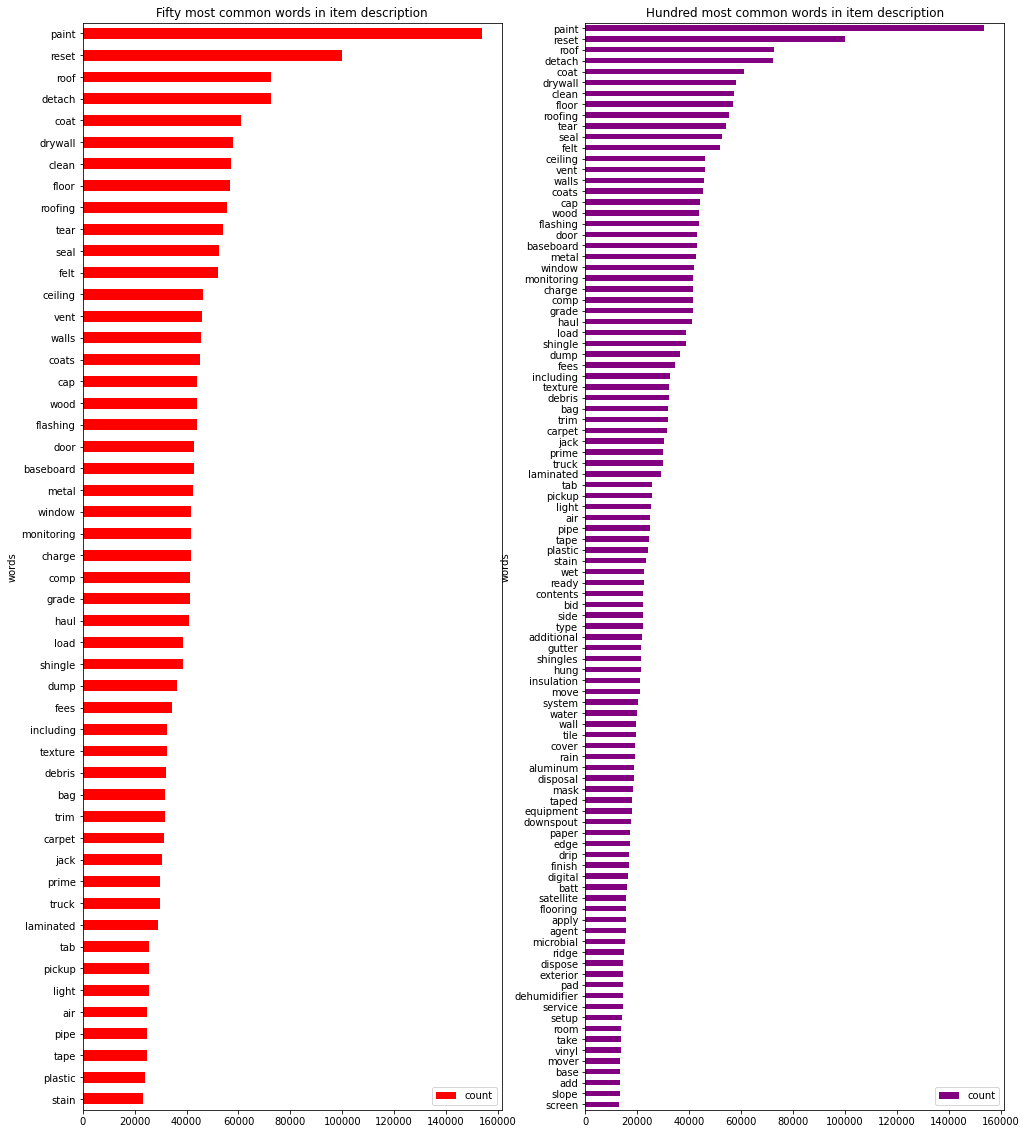

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2)

plt.subplots_adjust(left=1.6, right=3.2)

# Plot horizontal bar graph
most_frequent_words.head(50).sort_values(by='count').plot(kind='barh',
                    x='words',
                      y='count',
                      ax=ax1,
                      color="red",
                      figsize=(8, 20))

ax1.set_title("Fifty most common words in item description")

fig2 = most_frequent_words.head(100).sort_values(by='count').plot(kind='barh',
                    x='words',
                      y='count',
                      ax=ax2,
                      color="purple",
                    figsize=(8, 20))

ax2.set_title("Hundred most common words in item description")

plt.savefig('item_description_frequency_analysis.png', bbox_inches='tight', facecolor='w', dpi=600)
plt.show()

# fig2.savefig('item_description_frequency_analysis_50.png')
# fig2.savefig('item_description_frequency_analysis_100.png')





In [259]:
grouped = data.groupby('subcategory')
categories = list(grouped.groups)
print("Number of categories: {}".format(len(categories)))
print("Categories: {}".format(categories))

Number of categories: 120
Categories: ['accessories mobile home', 'acoustical treatments', 'antiques vintage goods', 'appliances', 'appliances major install', 'art restoration conservation', 'artwork', 'automotive motorcycle acc', 'awnings patio covers', 'books magazines periodicals', 'business goods equipment', 'cabinetry', 'cameras camcorders equip', 'cash securities', 'cleaning', 'clothing accessories', 'computers related goods', 'concrete asphalt', 'cont ceiling wall hangings', 'cont clean appliances', 'cont clean electric items', 'cont clean general items', 'cont clean hard furniture', 'cont clean lamps vases', 'cont clean upholstry soft', 'cont garment soft goods cln', 'cont packing handlng storage', 'content manipulation', 'credit', 'documents valuable papers', 'doors', 'drywall', 'electrical', 'electrical special systems', 'electronics', 'excavation', 'exterior structures', 'fees contents misc', 'fencing', 'finish carpentry trimwork', 'finish hardware', 'fire protection systems

Subcategories: [<font color='green'>'ACCESSORIES - MOBILE HOME'</font>, <font color='green'>'ACOUSTICAL TREATMENTS'</font>, 'ANTIQUES & VINTAGE GOODS', 'APPLIANCES', 'APPLIANCES - MAJOR W/O INSTALL', 'APPLIANCES - SMALL', 'ART RESTORATION, CONSERVATION', 'ARTWORK', 'AUTOMOTIVE & MOTORCYCLE ACC.', 'AWNINGS & PATIO COVERS', <font color='green'>'BOOKS, MAGAZINES & PERIODICALS'</font>, 'BUSINESS GOODS & EQUIPMENT', <font color='green'>'CABINETRY'</font>, <font color='green'>'CAMERAS, CAMCORDERS & EQUIP.'</font>, 'CASH & SECURITIES', 'CLEANING', <font color='green'>'CLOTHING & ACCESSORIES'</font>, <font color='green'>'COMPUTERS & RELATED GOODS'</font>, <font color='green'>'CONCRETE & ASPHALT'</font>, <font color='green'>'CONT: CEILING/WALL HANGINGS'</font>, 'CONT: CLEAN - GENERAL ITEMS', <font color='green'>'CONT: CLEAN - HARD FURNITURE'</font>, <font color='green'>'CONT: CLEAN - LAMPS OR VASES'</font>, 'CONT: CLEAN APPLIANCES', <font color='green'>'CONT: CLEAN ELECTRIC ITEMS'</font>, <font color='green'>'CONT: CLEAN,UPHOLSTRY & SOFT'</font>, <font color='green'>'CONT: GARMENT & SOFT GOODS CLN'</font>, 'CONT: PACKING,HANDLNG,STORAGE', 'CONTENT MANIPULATION', 'CREDIT', <font color='green'>'DOCUMENTS & VALUABLE PAPERS'</font>, <font color='green'>'DOORS'</font>, <font color='green'>'DRYWALL'</font>, <font color='green'>'ELECTRICAL'</font>, <font color='green'>'ELECTRICAL - SPECIAL SYSTEMS'</font>,<font color='green'> 'ELECTRONICS'</font>, <font color='green'>'EXCAVATION'</font>, 'EXTERIOR STRUCTURES', 'FEES - CONTENTS MISC.', <font color='green'>'FENCING'</font>, <font color='green'>'FINISH CARPENTRY / TRIMWORK'</font>, 'FINISH HARDWARE', 'FIRE PROTECTION SYSTEMS', 'FIREARMS & ACCESSORIES', 'FIREPLACES', <font color='green'>'FLOOR COVERING - CARPET'</font>, <font color='green'>'FLOOR COVERING - CERAMIC TILE'</font>, <font color='green'>'FLOOR COVERING - RESILIENT'</font>, <font color='green'>'FLOOR COVERING - STONE'</font>, <font color='green'>'FLOOR COVERING - VINYL'</font>, <font color='green'>'FLOOR COVERING - WOOD'</font>, <font color='green'>'FRAMING & ROUGH CARPENTRY'</font>, <font color='green'>'FURNITURE - HOME & OFFICE'</font>, 'GENERAL DEMOLITION', <font color='green'>'GLASS, GLAZING, & STOREFRONTS'</font>, <font color='green'>'HAZARDOUS MATERIAL REMEDIATION'</font>, 'HEALTH & MEDICAL SUPPLIES', <font color='green'>'HEAT,  VENT & AIR CONDITIONING'</font>, 'HEAVY EQUIPMENT', 'HOBBIES & COLLECTIBLES', <font color='green'>'HOUSEWARES - DINING & FLATWARE'</font>, <font color='green'>'HOUSEWARES - HOME DECOR'</font>, 'INFANT & BABY RELATED GOODS', <font color='green'>'INSULATION'</font>, <font color='green'>'INSULATION - MECHANICAL'</font>, <font color='green'>'INTERIOR LATH & PLASTER'</font>, <font color='green'>'JEWELRY & WATCHES'</font>, <font color='green'>'KITCHENWARE'</font>, 'LABOR ONLY', 'LANDSCAPING', <font color='green'>'LAWN, GARDEN & PATIO'</font>, <font color='green'>'LIGHT FIXTURES'</font>, <font color='green'>'LINENS & SOFTGOODS'</font>, 'LUGGAGE, BAGS & ACCESSORIES', <font color='green'>'MARBLE - CULTURED OR NATURAL'</font>, 'MASONRY', <font color='green'>'METAL STRUCTURES & COMPONENTS'</font>, <font color='green'>'MIRRORS & SHOWER DOORS'</font>, 'MISC. EQUIPMENT - AGRICULTURAL', 'MISC. EQUIPMENT - COMMERCIAL', 'MOBILE HOMES, SKIRTING & SETUP', 'MOISTURE PROTECTION', 'MUSIC, MOVIES & MEDIA', 'MUSICAL INSTRUMENTS & EQUIP.', 'OFFICE SUPPLIES', <font color='green'>'ORNAMENTAL IRON'</font>, 'PAINTING', 'PANELING & WOOD WALL FINISHES', 'PERISHABLE - NON-PERISHABLE', 'PERMITS AND FEES', 'PERSONAL CARE & BEAUTY', 'PET & ANIMAL SUPPLIES', <font color='green'>'PLUMBING'</font>, <font color='green'>'ROOFING'</font>, <font color='green'>'SCAFFOLDING'</font>, <font color='green'>'SIDING'</font>, <font color='green'>'SOFFIT, FASCIA, & GUTTER'</font>, 'SPECIALTY ITEMS', 'SPORTING GOODS & OUTDOORS', <font color='green'>'STAIRS'</font>, <font color='green'>'STEEL COMPONENTS'</font>, <font color='green'>'STEEL JOIST COMPONENTS'</font>, <font color='green'>'STUCCO & EXTERIOR PLASTER'</font>, <font color='green'>'SWIMMING POOLS & SPAS'</font>, 'TEMPORARY REPAIRS', <font color='green'>'TILE'</font>, <font color='green'>'TIMBER FRAMING'</font>, <font color='green'>'TOILET & BATH ACCESSORIES'</font>, 'TOOLS', 'TOYS & GAMES', 'TRAUMA/CRIME SCENE REMEDIATION', 'USER DEFINED ITEMS', <font color='green'>'WALLPAPER'</font>, 'WATER EXTRACTION & REMEDIATION', <font color='green'>'WINDOW REGLAZING & REPAIR'</font>, <font color='green'>'WINDOW TREATMENT'</font>, <font color='green'>'WINDOWS - ALUMINUM'</font>, <font color='green'>'WINDOWS - SKYLIGHTS'</font>, <font color='green'>'WINDOWS - SLIDING PATIO DOORS'</font>, <font color='green'>'WINDOWS - VINYL'</font>, <font color='green'>'WINDOWS - WOOD']</font>

In [65]:
data = pd.read_csv(processed_file)

In [66]:
import re, os, sys

data = data.rename(columns={"subcategory" : "subcategory_prev"})
data["category"] = ""
data["subcategory"] = ""

print(data.columns.tolist())

category_map = {
    "Construction/Demolition Waste" : {
        "Stone" : ["stone"], 
        "Masonry" : ["mansory"],
        "Marble" : ["marble", "marbling"],
        "Plaster" : ["plaster", "plaster", "plastering"],
        "Acoustic panel" : ['acoustic panel', 'acoustical panel', 'acoustical treatment'],
        "Insulation" : ["insulation"],
        "Ceiling" : ["ceiling"],
        "Walls" : ["wall", "walls"],
        "Scaffolding" : ["scaffold", "scaffolding"],
        "Plumbing" : ["plumb", "plumbing"],
        "Roof" : ["roof", "roofing"],
        "Doors" : ["door", "doors"],
        "Cabinets/cabinetry" : ["cabinet", "cabinetry"],
        "Floor" : ["floor", "flooring"],
        "Drywall" : ["drywall"],
        "Windows" : ["window", "windows"],
        "Dashboard" : ["dashboard"],
        "Asphalt" : ["asphalt"],
        "Stairs" : ["stairs"],
        "Carpentry" : ["carpentry"],
        "Fencing" : ["fence", "fencing"],
        "Mansory" : ["mansory"],
        "Gutter" : ["gutter"],
        "Siding" : ["siding"]
    },
    "Hazardous Waste" : {
        "Paint" : ["paint", "painting"],
        "Window treatment" : ["window treatment"],
        "Automative parts/automative accessories" : ["automative"],
        "Asphalt" : ["asphalt"],
        "Swimming pool waste and accessories" : ["swimming pool"],
        "Medical waste" : ["medic waste"]
    },
    "Electronic Waste" : {
        "Electronics equipment" : ["electric", "electrical", "electronic"], 
        "Camera" : ["camera", "cameras"], 
        "Computer" : ["computer", "computers"]
    },
    "Textiles" : {
        "Cloth" : ["cloth", "clothing", "clothes"], 
        "Linen" : ["linen"],
        "Upholstery" : ["upholstery"]
    },
    "Plastics" : {
        "Vinyl" : ["vinyl"], 
        "Plastics" : ["plastic", "plastics"], 
        "Polymer" : ["polymer", "polymers"]
    },
    "Glass" : {
        "Glass" : ["glass"], 
        "Mirror" : ["mirror", "mirrors"], 
        "Lamp" : ["lamp", "lamps"], 
        "Skylight" : ["skylight", "skylights"]
    },
    "Metals" : {
        "Metal" : ["metal"], 
        "Steel jost and components" : ["steel"],
        "Iron" : ["iron"],
        "Copper" : ["copper"],
        "Aluminum" : ["aluminum"],
        "Precious metals" : ["precious metal", "jewel", "jewelry"]
    },
    "Wood" : {
        "Wood" : ["wood"],
        "Wood" : ["wood furniture"],
        "Timber" : ["timber"],
        "Hard furniture" : ["hard furniture"]
    },
    "Paper/Cardboard" : {
        "Paper" : ["paper","papers"],
        "Periodicals" : ["periodical","periodicals"],
        "Books" : ["book", "books"],
        "Documents" : ["document", "documents"]
    },
    "White Goods/Household Appliances" : {        
        "Appliances" : ["appliance", "appliances"],
        "Heavy equipment" : ["heavy equipment"],
        "Heat vents" : ["heat vent"],
        "Air vents" : ["air condition", "air vent"],
        "Cleaning appliances" : ["clean", "cleaning"]
    },
    "Tree Trimmings/Yard Waste" : {
        "Trees" : ["tree", "trees"],
        "Lawn yard waste" : ["lawn"],
        "Trim waste" : ["trim"]
    },
    "General Solid Waste Collection" : {
        "Home decor" : ["home decor"],
        "Clean up waste" : ["cleanup", "clean up"],
        "Collectibles" : ["collectible", "collectibles"],
        "Houseware" : ["houseware", "kitchenware"],
        "Artwork" : ["art", "arts", "artwork"],
        "Business goods" : ["business goods"],
        "Toys/games" : ["toy", "game"],
        "Home office goods" : ["office goods", "goods"],
        "Accessories" : ["accessories", "accessory"]
    }   
}

def format_and_regex_expression(expr):
    
    if len(expr.split()) <= 1:
        return expr
    
    regex_words = ["(?i:{})".format(w) for w in expr.split()]
    
    return "(^.*" + ".*".join(regex_words) + ".*$)"

category_regex = {}
for category, subcategory_map in category_map.items(): 
    category_regex[category] = {}
    for subcategory, patterns in subcategory_map.items():
        category_regex[category][subcategory] = "|".join([format_and_regex_expression(p) for p in patterns])
    

def add_tag(data, mask, tag_col, tag):
        """
        Aggregates multiple tags in the single value of type tag1,tag2,tag3,...
        :param data:           an input DataFrame
        :param mask:            an input DataFrame mask     
        :param tag_col:         name of the tag column
        :param tag:             an input tag to incorporate in tag column
        """
        if tag_col == "category":
            tag_mask = (data[tag_col].fillna("") != "")
            logging.warning("{}/{} items already belong to {} or other lists".format((mask & tag_mask).sum(),
                                                                    data.shape[0],
                                                                    tag
                                                                )
                        )
        else:
            tag_mask = data[tag_col].fillna("").str.contains(tag+",") | data[tag_col].fillna("").str.contains(","+tag) | (data[tag_col] == tag)
            logging.warning("{}/{} items are already tagged as {}".format((mask & tag_mask).sum(),
                                                                    data.shape[0],
                                                                    tag
                                                                )
                        )

        logging.warning("Tagged {}/{} items as {}".format((mask & (~tag_mask)).sum(),
                                                                    data.shape[0],
                                                                    tag
                                                                )
                       )
        def add_tag_to_str(x, tag):
            
            if x == "":
                return tag

            if not tag+"," in x and not ","+tag in x:
                x = x + "," + tag

            return x

        if (mask & (~tag_mask)).sum() > 0:
            data.loc[mask & (~tag_mask), tag_col] = data.loc[mask & (~tag_mask), tag_col].fillna("").apply(lambda x: add_tag_to_str(x, tag))

        return data


for category, subcategory_map in category_regex.items():
    for subcategory, pattern in subcategory_map.items():
        mask = data["subcategory_prev"].astype(str).str.contains(pattern, flags=re.IGNORECASE)
        data = add_tag(data, mask, "subcategory", subcategory)
        data = add_tag(data, mask, "category", category)
    logging.warning("Tagged in total {}/{} items as {}".format((data["category"] == category).sum(),
                                                                    data.shape[0],
                                                                    category
                                                                ))

categorized_file = '{}/Pentatonic_Xact_Categories_5yr_categorized.csv'.format(data_path)
save_data_to_csv(data, categorized_file, index=False)


['subcategory_prev', 'item_description', 'div_cd', 'ls_date', 'state', 'zip', 'reason', 'primary_col_desc', 'item_unit_cd', 'item_quantity', 'count', 'category', 'subcategory']


In [62]:
categories_file = "data/categories_stats.csv"
subcategories_file = "data/subcategories_stats.csv"

categories_stats = {}
categories = []
counts = []

subcategories_stats = {}
subcategories = []
subcounts = []

for category, subcategory_map in category_regex.items():
    cat_mask = data["category"].fillna("").str.contains(category+",") | data["category"].fillna("").str.contains(","+category) | (data["category"] == category)
    count = cat_mask.sum()
    categories.append(category)
    counts.append(count)
    for subcategory, pattern in subcategory_map.items():
        subcat_mask = data["subcategory"].fillna("").str.contains(subcategory+",") | data["subcategory"].fillna("").str.contains(","+subcategory) | (data["subcategory"] == subcategory)
        subcount = subcat_mask.sum()
        subcategories.append(subcategory)
        subcounts.append(subcount)

categories_stats["category"] = categories
categories_stats["count"] = counts

subcategories_stats["subcategory"] = subcategories
subcategories_stats["count"] = subcounts
    
categories_stats_df = pd.DataFrame.from_dict(categories_stats).sort_values(by=['count'], ascending=False)
save_data_to_csv(categories_stats_df, categories_file, index=False)

subcategories_stats_df = pd.DataFrame.from_dict(subcategories_stats).sort_values(by=['count'], ascending=False)
save_data_to_csv(subcategories_stats_df, subcategories_file, index=False)


In [ ]:
subcategories_file = "data/subcategories_stats.csv"

subcategories_stats = {}

subcategories = []
counts = []
for category in category_regex:
    for subcate
    cat_mask = data["category"].fillna("").str.contains(category+",") | data["category"].fillna("").str.contains(","+category) | (data["category"] == category)
    count = cat_mask.sum()
    categories.append(category)
    counts.append(count)

categories_stats["category"] = categories
categories_stats["count"] = counts
    
categories_stats_df = pd.DataFrame.from_dict(categories_stats).sort_values(by=['count'], ascending=False)
save_data_to_csv(categories_stats_df, categories_file, index=False)



In [68]:
def save_data_to_csv(data, filename, **kwargs):
        """
        Save df to csv
        :param data: df to save
        :param filename: path to file
        :param kwargs: additional arguments for DataFrame.to_csv method
        """
        dirname = os.path.dirname(filename)
        os.makedirs(dirname, exist_ok=True)
        data.to_csv(filename, **kwargs)
        
def save_data_to_excel(data, filename, **kwargs):
        """
        Save df to csv
        :param data: df to save
        :param filename: path to file
        :param kwargs: additional arguments for DataFrame.to_csv method
        """
        dirname = os.path.dirname(filename)
        os.makedirs(dirname, exist_ok=True)
        data.to_excel(filename, **kwargs)

csv_file = ("data/Pentatonic_Xact_Categories_5yr_v1.csv")
save_data_to_csv(data, csv_file, index=False)

['WINDOWS - ALUMINUM',
 'WINDOWS - SKYLIGHTS',
 'WINDOWS - SLIDING PATIO DOORS',
 'WINDOWS - VINYL',
 'WINDOWS - WOOD']

In [1]:
import pandas as pd

data = pd.read_csv("~/Downloads/zip_code_database_enterprise.csv")
data[data["state"] == "TX"]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,...,pop_70_to_79,pop_80_plus,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_high_school_graduate,percent_bachelors_degree,percent_graduate_degree
32149,73301,UNIQUE,0,Austin,NaN,Internal Revenue Service,TX,Travis County,America/Chicago,512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32150,73344,UNIQUE,0,Austin,NaN,Internal Revenue Service,TX,Travis County,America/Chicago,512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32363,73960,PO BOX,0,Texhoma,NaN,NaN,TX,Sherman County,America/Chicago,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32759,75001,STANDARD,0,Addison,NaN,NaN,TX,Dallas County,America/Chicago,214,...,342.0,137.0,10.8603,50263.0,72512.0,1351.0,321000.0,90.7897,50.3407,17.0876
32760,75002,STANDARD,0,Allen,"Lucas, Parker",NaN,TX,Collin County,America/Chicago,"214,469,972",...,1658.0,772.0,4.8943,46203.0,101429.0,1527.0,276000.0,94.7575,44.6250,13.5284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37939,88587,PO BOX,0,El Paso,NaN,NaN,TX,El Paso County,America/Denver,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37940,88588,PO BOX,0,El Paso,NaN,NaN,TX,El Paso County,America/Denver,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37941,88589,PO BOX,0,El Paso,NaN,NaN,TX,El Paso County,America/Denver,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37942,88590,PO BOX,0,El Paso,NaN,NaN,TX,El Paso County,America/Denver,915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['zip', 'type', 'decommissioned', 'primary_city', 'acceptable_cities',
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'country', 'approximate_latitude',
       'approximate_longitude', 'population_center_latitude',
       'population_center_longitude', 'polygon_offset_latitude',
       'polygon_offset_longitude', 'internal_point_latitude',
       'internal_point_longitude', 'latitude_min', 'latitude_max',
       'longitude_min', 'longitude_max', 'area_land', 'area_water',
       'housing_count', 'irs_estimated_households', 'acs_estimated_households',
       'population_count', 'irs_estimated_population',
       'acs_estimated_population', 'white', 'black_or_african_american',
       'american_indian_or_alaskan_native', 'asian',
       'native_hawaiian_and_other_pacific_islander', 'other_race',
       'two_or_more_races', 'total_male_population', 'total_female_population',
       'pop_under_10', 'pop_10_to_19', 'pop_20_to_29', 'po

In [2]:
def load_zipcode_map(filename, states=[], data=None):
    
        data = pd.read_csv(filename)

        if data is None:
            logging.error("ZIP code database not found")
            raise Exception("Zip mapping failed due to exception: ZIP code database not found")

        try:
            data = data[["zip", "primary_city", "state", "county", "housing_count", "population_count"]]
        except Exception as e:
            logging.error("Failed to load data from ZIP code database")
            raise Exception(e)

        if len(states) > 0:
            state_mask = data["state"].isin(states)

            if state_mask.sum() > 0:
                logging.info("Found {} valid ZIP codes for states {}".format(state_mask.sum(), states))
                data = data[state_mask]
                
        return data

In [81]:
def calculate_zip_code_mapping(categorised_claims, filename, data=None):

        if data is None:
            data = categorised_claims.copy()

            states = []
            zipcode_data = load_zipcode_map(filename="/Users/user/Documents/Pentatonic/Travelers/data/zip_code_database_enterprise.csv", states=states)

            if zipcode_data is None:
                print("No ZIP data loaded. Returning initial data set")
                return dat
            
            data = data[["category", "subcategory", "zip", "state"]].join(zipcode_data[["zip", "primary_city", "county", "state"]].set_index("zip"), lsuffix="_cat", rsuffix="_zip", how="left", on=["zip"])

        return data
    
def match_zip_codes(data, filename):

    no_zip_mask = data["zip"].isna()

    if no_zip_mask.sum() > 0:
        print("Total {}/{} claims have no ZIP code associated".format(no_zip_mask.sum(),
                                                                                    data.shape[0]
                                                                                    ))

    states = []
    zipcode_data = load_zipcode_map(filename="/Users/user/Documents/Pentatonic/Travelers/data/zip_code_database_enterprise.csv", states=states)

    if zipcode_data is None:
        print("No ZIP data loaded. Returning initial data set")
        return data
            
    data = data.merge(zipcode_data[["zip", "primary_city", "state", "county"]], suffixes=("_claim", "_zip"), how="left", on=["zip"])

    wrong_state_mask = (data["state_claim"] != data["state_zip"])
            
    if wrong_state_mask.sum() > 0:
        print("Total {}/{} claims have wrong state associated".format(wrong_state_mask.sum(),
                                                                                    data.shape[0]
                                                                                    ))
        
    outside_texas_mask = (data["state_zip"] != "TX")
    
    if outside_texas_mask.sum() > 0:
        print("Total {}/{} claims have wrong state associated".format(outside_texas_mask.sum(),
                                                                                    data.shape[0]
                                                                                    ))
        
    #data = data.drop(columns=["state_claim"]).rename(columns={"state_zip" : "state"})
    
    data = data.drop(columns=[c for c in data.columns if c.endswith("_claim")])
    
    data = data.rename(columns={"state_zip" : "state"})

    return data

In [82]:
claims_data = pd.read_csv("/Users/user/Documents/Pentatonic/Travelers/data/output/Pentatonic_Xact_Categories_5yr_categorized.csv")

In [155]:
claims_data["zip"].fillna(0).astype(int)

0         76063
1         76110
2         79902
3         75220
4         75206
          ...  
970130    78212
970131    79407
970132    79936
970133    75460
970134    77954
Name: zip, Length: 970135, dtype: int64

In [57]:
pp_data = calculate_zip_code_mapping(categorised_claims=claims_data, filename="/Users/user/Documents/Pentatonic/Travelers/data/zip_code_database_enterprise.csv")
no_zip_mask = pp_data["zip"].isna()
# pp_data[pp_data["state_zip"] != "TX"]

967828

In [145]:
pp_data

,subcategory,zip
63,Printers/Faxes/Scanners,"77040.0,78238.0,79902.0"


In [194]:
pp_data = pd.read_csv("/Users/user/Documents/Pentatonic/Travelers/data/output/category_zipcode_map.csv")
# pp_data = pd.read_csv("/Users/user/Documents/Pentatonic/Travelers/data/output/subcategory_zipcode_map.csv")
# pp_data = pp_data[pp_data["subcategory"] == "Printers/Faxes/Scanners"].copy()
# map_data["zip"] = map_data["zip"].str.split(',', expand=True)
# map_data = map_data.drop_duplicates(subset=["zip"])
# map_data["zip"] = map_data["zip"].astype(str)
# # map_data["category"] = 0.8
# map_datav


In [195]:
import folium

for category in pp_data["category"]:
    
    data = pp_data[pp_data["category"] == category].copy()

    zip_codes = data["zip"].values[0].split(",")


    texas_map = folium.Map(location=[31.906490, -98.624192], zoom_start=6)

    # folium.Choropleth(
    #     geo_data="/Users/user/Documents/Pentatonic/Travelers/data/tx_texas_zip_codes_geo.min.json",
    #     data=map_data,
    #     columns=['ZIP', 'category'],
    #     key_on='feature.properties.ZCTA5CE10',
    #     fill_color='YlOrRd', 
    #     fill_opacity=0.7, 
    #     line_opacity=0.2,
    #     legend_name='Industrial equipment'
    # ).add_to(texas_map)

    texas_layer = folium.GeoJson(
        data="/Users/user/Documents/Pentatonic/Travelers/data/tx_texas_zip_codes_geo.min.json",
        style_function=lambda feature: {
            'fillColor': '#006400' if feature["properties"]["ZCTA5CE10"] in zip_codes else '#ffff00',
            'fill_opacity': 0.3,
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5'
        }, 
        zoom_on_click=True
    ).add_to(texas_map)

    folium.LayerControl().add_to(texas_map)

    texas_map.fit_bounds(texas_layer.get_bounds())
    
    file_name = category.lower().replace(" ","_").replace("/","_").replace(" ","_") + '.html'
    
    texas_map.save('data/output/zipcode_maps/{}'.format(file_name))

In [190]:
texas_map.save('data/output/industrial_equipment.html')

In [133]:
import json
geodata = json.load(open("/Users/user/Documents/Pentatonic/Travelers/data/tx_texas_zip_codes_geo.min.json"))



In [142]:
print(zip_codes)
for f in geodata["features"]:
    if f["properties"]["ZCTA5CE10"] in zip_codes:
        print(f["properties"]["ZCTA5CE10"])

['77040.0', '78238.0', '79902.0']


In [78]:
def aggregate_col_values_to_comma_list(col):
    """
        Aggregate all column values in a comma separated list
    """
    return ','.join(set(col.astype(str).values.tolist()))

In [79]:
ppp_data = ppp_data[["category", "zip", "primary_city", "state", "county"]].groupby(["category"]).agg({
                                    
                                    "zip" : aggregate_col_values_to_comma_list,
                                    "primary_city" : aggregate_col_values_to_comma_list,
                                    "state" : aggregate_col_values_to_comma_list,
                                    "county" : aggregate_col_values_to_comma_list
                                    })

In [80]:
ppp_data

,zip,primary_city,state,county
category,,,,
Construction/Demolition Waste,"78753.0,76530.0,79054.0,79911.0,76904.0,78054....","West,O Brien,Forreston,Thornton,Ralls,Harleton...",TX,"Hood County,Mercer County,Collingsworth County..."
Electronic Waste/Scrap metals,"78753.0,76530.0,79911.0,76904.0,78054.0,76643....","West,O Brien,Thornton,Ralls,Harleton,Smyer,Bur...",TX,"Hood County,Collingsworth County,Jack County,L..."
Furniture,"76118.0,76667.0,76904.0,76643.0,78741.0,77373....","Mabank,Irving,Denison,Grapevine,Burleson,Pasad...",TX,"Hood County,Potter County,Webb County,Dallas C..."
General Solid Waste Collection,"78753.0,79556.0,78220.0,76118.0,76667.0,76904....","West,Smyer,Burleson,Pasadena,Bridgeport,Aransa...",TX,"Loudoun County,Hood County,Loving County,Duval..."
Glass,"78753.0,76530.0,79911.0,76667.0,76904.0,75148....","Ralls,Burleson,Pasadena,Kopperl,Mckinney,Pampa...",TX,"Hood County,Lamb County,Oldham County,Potter C..."
Hazardous Waste,"78753.0,76530.0,79911.0,76904.0,78054.0,76643....","West,O Brien,Forreston,Ralls,Harleton,Smyer,Bu...",TX,"Hood County,Mercer County,Jack County,Lamb Cou..."
Industrial equipment,"78753.0,78220.0,76118.0,76667.0,76904.0,75148....","Burleson,Bridgeport,Ravenna,Mckinney,De Leon,P...",TX,"Hood County,Collingsworth County,Jack County,L..."
Metals,"79351.0,78753.0,79556.0,78220.0,76118.0,76667....","West,Ralls,Burleson,Pasadena,Bridgeport,Rivers...",TX,"Hood County,Mercer County,Collingsworth County..."
Paper/Cardboard,"79351.0,78753.0,76118.0,76667.0,76904.0,77418....","West,Burleson,Pasadena,Bridgeport,Kopperl,Mcki...",TX,"Hood County,Potter County,Webb County,McCulloc..."


In [204]:
cc = pd.read_csv("/Users/user/Documents/Pentatonic/Travelers/data/output/category_zipcode_map.csv")


cc

,category,zip
0,Construction/Demolition Waste,"73301,73960,75001,75002,75006,75007,75009,7501..."
1,Electronic Waste/Scrap metals,"73301,73960,75001,75002,75006,75007,75009,7501..."
2,Furniture,"75002,75006,75007,75010,75023,75025,75050,7506..."
3,General Solid Waste Collection,"73301,73960,75001,75002,75006,75007,75009,7501..."
4,Glass,"73960,75001,75002,75006,75007,75010,75013,7501..."
5,Hazardous Waste,"73301,75001,75002,75006,75007,75009,75010,7501..."
6,Industrial equipment,"75032,75035,75048,75057,75061,75067,75071,7507..."
7,Metals,"73301,75001,75002,75006,75007,75009,75010,7501..."
8,Paper/Cardboard,"73301,73960,75001,75002,75006,75007,75010,7501..."
9,Plastics,"75001,75002,75006,75007,75009,75010,75013,7501..."


In [203]:
cc.head(10)

,item_description,ls_date,zip,reason,item_unit_cd,item_quantity,count,state,county,category,subcategory
0,WATERPROOF PANELING TRIM PREMIUM GRADE,201910,76063.0,Hail,SF,324.28,2,TX,Tarrant County,"Construction/Demolition Waste,Wood,Tree Trimmi...","Walls,Roof,Wood,Trim waste"
1,WATERPROOF PANELING TRIM PREMIUM GRADE,201609,76110.0,Water (NW),SF,73.33,1,TX,Tarrant County,"Construction/Demolition Waste,Wood,Tree Trimmi...","Walls,Roof,Wood,Trim waste"
2,WATERPROOF PANELING TRIM HIGH GRADE,201605,79902.0,Water (NW),SF,413.42,1,TX,El Paso County,"Construction/Demolition Waste,Wood,Tree Trimmi...","Walls,Roof,Wood,Trim waste"
3,WATERPROOF PANELING TRIM COMMERCIAL FRP,201910,75220.0,Wind,SF,404.39,1,TX,Dallas County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
4,WATERPROOF PANELING TRIM COMMERCIAL FRP,201906,75206.0,Fire/Smoke,SF,277.98,1,TX,Dallas County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
5,WATERPROOF PANELING TRIM COMMERCIAL FRP,201905,77365.0,Water (W),SF,193.00,2,TX,Montgomery County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
6,WATERPROOF PANELING TRIM COMMERCIAL FRP,201904,77520.0,Water (NW),SF,320.00,1,TX,Harris County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
7,WATERPROOF PANELING TRIM COMMERCIAL FRP,201710,76155.0,Water (NW),SF,1600.20,5,TX,Tarrant County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
8,WATERPROOF PANELING TRIM COMMERCIAL FRP,201709,75647.0,All Other,SF,92.00,1,TX,Gregg County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."
9,WATERPROOF PANELING TRIM COMMERCIAL FRP,201708,77081.0,Water (W),SF,228.00,2,TX,Harris County,"Construction/Demolition Waste,Electronic Waste...","Walls,Roof,Safety/Security Systems,Wood,Trim w..."


In [39]:
cc.shape[0]

970135

In [130]:
import numpy as np
import pandas as pd

data = pd.read_csv("data/output/Pentatonic_Xact_Categories_5yr_categorized.csv")
data['year'] = pd.DatetimeIndex(pd.to_datetime(data['ls_date'], format="%Y%m")).year

data = data.assign(**{"subcategory":data["subcategory"].str.split(',')})
data = data.explode("subcategory")

yearly_data = data[["subcategory", "item_quantity", "item_unit_cd", "year"]]\
                .groupby(["subcategory", "year", "item_unit_cd"], as_index=False)\
                .agg(median_item_quantity=('item_quantity', np.median),total_item_quantity=('item_quantity', np.sum))
yearly_data = yearly_data.reset_index().round(1)

total_yearly_data = data[["year", "item_quantity", "item_unit_cd"]]\
                .groupby(["year", "item_unit_cd"], as_index=False)\
                .agg(total_item_quantity=('item_quantity', np.sum))
total_yearly_data = total_yearly_data.reset_index().round(1)
    
with pd.ExcelWriter("output.xlsx", engine='openpyxl') as writer:
    yearly_data.to_excel(writer, sheet_name="Subcategories")
    total_yearly_data.to_excel(writer, sheet_name="Years")






In [7]:
data['ls_date'] = pd.to_datetime(data['ls_date'], format='%y%m')
data

ValueError: unconverted data remains: 910

In [92]:
data = pd.read_csv("data/output/Pentatonic_Xact_Categories_5yr_categorized.csv")
# print(data.loc[data["subcategory"].astype(str).str.contains("Weapons"), "item_quantity"].shape[0])

# print(data.loc[data["subcategory"].isin(["Weapons"]), "item_quantity"].shape[0])
x = data.assign(**{"subcategory":data["subcategory"].str.split(',')})
ss = x.explode("subcategory")
ss
ss.loc[ss["subcategory"].isin(["Weapons"]), "item_quantity"].sum()

12643.5

In [133]:
f = "subcategory_{type}_report.{{extension}}"
f = f.format(type="dick")
f

'subcategory_dick_report.{extension}'

In [139]:
ll = "%(output_dir)s/sfds/subcategory_{type}_report.{{extension}}".split("/")
ll[-1]

'subcategory_{type}_report.{{extension}}'

In [142]:
import json
with open("data/output/categories_stats.json", "r") as f:
    dd = json.load(f)

In [152]:
data = pd.DataFrame.from_dict({(i,j,k): dd[i][j][k] 
                           for i in dd.keys() 
                           for j in dd[i].keys()
                              for k in dd[i][j].keys()}, orient='index')
data

AttributeError: 'int' object has no attribute 'items'

In [5]:
n = 3
ll = "aa bb cc dd ee"
ll = [" ".join(ll.split()[i:i+n]) for i in range(0, len(ll.split()), n)]
ll

['aa bb cc', 'dd ee']

In [7]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
ls = LancasterStemmer()

lm = WordNetLemmatizer()

In [12]:
word = "troubl"
print(ps.stem(word))
print(ls.stem(word))

troubl
troubl


In [22]:
from nltk.corpus import wordnet
syns = wordnet.synsets("carefully")
print(syns)

[Synset('carefully.r.01'), Synset('cautiously.r.01')]


In [32]:
wordnet.synset('dog.n.01').lemma_names()

['dog', 'domestic_dog', 'Canis_familiaris']

In [29]:
ADVERBS = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('a')}

In [35]:
import re
expr = "Hold-a-bat/dick with"
txt = re.sub('[/-]', ' ', expr)
txt

'Hold a bat dick with'

In [3]:
import pandas as pd
data = pd.read_excel("/Users/user/Documents/Pentatonic/Travelers/data/app_export_weight_db_v0.5.2.xlsx")
data.index

RangeIndex(start=0, stop=1629, step=1)

In [4]:
data.to_csv("/Users/user/Documents/Pentatonic/Travelers/data/app_export_weight_db_v0.5.2.csv", index=False)

In [54]:
re.sub('[/-]', '', "A/C-").isalpha()

True

In [5]:
import pandas as pd

In [6]:
data.to_csv("/Users/user/Downloads/static_2021-11-13.csv", index=False)

In [7]:
data = pd.read_csv("/Users/user/Downloads/static_2021-11-13.csv")

In [10]:
data["allamazonformats"].to_csv("/Users/user/Downloads/allamazonformats.csv", index=False)

In [11]:
len("{'Flexibound': '1607107287', 'Mass Market Paperback': '055321313X', 'Audible Audiobook': 'B07HCK8RVY', 'Kindle': 'B074M91NDF', 'MP3 CD, Audiobook, MP3 Audio': '153666667X', 'Kindle Edition': 'B07Q2HSVFZ', 'Hardcover': '150982801X', 'Paperback': '1730905897'}")

258

In [12]:
258*4

1032